First, identify Predictor (Input) and Target (output) variables. Next, identify the data type and category of the variables.

https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/

Categorical : client_state, churn, BC 
Continous : CPL_wrt_BC, duration, num_prods, calls, CPL_wrt_self, avg_budget, clicks
predictor variables : CPL_wrt_BC, duration, num_prods, calls, CPL_wrt_self, avg_budget, clicks, client_state, BC
Target variable : churn

In [2]:
#%matplotlib inline
#Data manipulation 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

#Data Visulization 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib #saving the model
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE # balancing data
#Data Modeling 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ClassificationReport
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

###### Classifiers #####
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## DL ##
from keras import Sequential
from keras.layers import Dense


def get_data(csv_file_name, header_file_name):
    
    """
    Gets the data file and adds the header to data
    """

    header = []
    lines = [line.rstrip() for line in open(header_file_name)] # get the header file
    for line in lines:
        header.append(line.replace(',',''))
        
    missing_values = ["n/a", "na", "--", ""] # Making a list of missing value types
       
    df = pd.read_csv(csv_file_name, names=header, skipinitialspace=True, na_values=missing_values) # read the csv file 
    
    df['BC']  = label_encoding(df,'BC') # categorical to numeric variable
    df['client_state'] = label_encoding(df,'client_state') #categorical to numeric variable
    
    #for key in df.keys():
    #df = detect_outlier(df, 'CPL_wrt_BC')
 
    
    
    df.to_csv('data_cleaned.csv')
    
    return df

def detect_outlier(data):
    """
    @detects outlier using Z-Score (y - mean)/std
    """
    
    outliers=[]
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    
    return outliers


def column_to_binary(df, namecol):  
    """
    converts categorical a feature to binary  
    I have not used it since we will have my features!!!
    """
    df = df.copy()
    df = pd.get_dummies(df, columns=[namecol], prefix = [namecol])

    return df


def correlation_test(df):
    """
    displays the corelations among all the features of input data frame
    """
    plt.figure(figsize=(12, 8))
    vg_corr = df.corr()
    sns.heatmap(vg_corr, 
            xticklabels = vg_corr.columns.values,
            yticklabels = vg_corr.columns.values,
            annot = True)

    
def label_encoding(df, columnName):

    """
    Converts categorical to numeric variable
    """
    le = preprocessing.LabelEncoder()
    df[columnName] = le.fit_transform(df[columnName])
    
    return df[columnName]


def model_ML(data):
    
    data = data.fillna(data.mean())
    
    """
    creates a machine learning model using RandomForestClassifier 
    uses pipeline to impute the missing values and replace with most frequent strategy
    standardizes the features to get standard normally distributed data  
    """
    X = data.drop('churn', axis=1).values #features 
    y = data['churn'].values #target

    #imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #setup the imputation
    imp = SimpleImputer(missing_values=np.nan, strategy='mean') #setup the imputation

    
    #n_estimators (The number of trees in the forest)
    clf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=2)
     
     ### oversampling 
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(X, y)

    steps = [('imputation', imp),
             ('scaler', StandardScaler()),
             ('clf', clf )]

    pipeline = Pipeline(steps) # creat piplien 
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 2)
    model = pipeline.fit(X_train, y_train) #fit the model
    y_pred = pipeline.predict(X_test) # predict the response
    y_prob=pipeline.predict_proba(X_test) # prob for each record

    
    # evaluate accuracy
    print('ML model accuracy score for the test:', pipeline.score(X_test,y_test)) #whether or not the model has over fited

    print ("ML model accuracy score:", accuracy_score(y_test, y_pred))
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    print('Model Performance:')
    target_names = ['retention', 'churn']
    
    # making prediction for out of sample data
    sample = [[-0.104875203,12,18,1,9,-0.084501058,768.3529346,23,98], 
              [-0.082850078,11,42,1,4,-0.319290368,661.7538154,5,150],
              [0.180727928,5,12,2,4,0.377594573,3639.980843,10,144],
              [-0.062326729,10,8,1,5,-0.833590931,625,7,85],
              [0.334965528,14,15,3,8,0.262987328,3266.800831,7,63]]

    preds = model.predict(sample) 
    pred_churn = [target_names[p] for p in preds] 
    print("Predictions:", pred_churn)

    return model


def model_DL(data):
    
    """
    creates a deep learning model with 2 hidden layers and 1 output -- this is inactive now
    """
    data= data.fillna(data.mean())
    
    X = data.drop('churn', axis=1).values #features 
    y = data['churn'].values #target
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model = Sequential()
    model.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=9)) #1st HL
    model.add(Dense(4, activation='relu', kernel_initializer='random_normal'))  #2nd  HL
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal')) #Output
    model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy']) # Compiling the NN
    model.fit(X_train, y_train, batch_size=10, epochs=10) #Fitting the data to the training dataset

    eval_model = model.evaluate(X_train, y_train)
    print(eval_model)
    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # making prediction for out of sample data #1st and last must be churn
    Xnew = [[-0.104875203,12,18,1,9,-0.084501058,768.3529346,23,98], 
              [-0.082850078,11,42,1,4,-0.319290368,661.7538154,5,150],
              [0.180727928,5,12,2,4,0.377594573,3639.980843,10,144],
              [-0.062326729,10,8,1,5,-0.833590931,625,7,85],
              [0.334965528,14,15,3,8,0.262987328,3266.800831,7,63]]
    
    for i in range(0,len(Xnew)):
        # make a prediction
        ynew = model.predict(np.array(Xnew))
        # show the inputs and predicted outputs
        print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))

def main():
    """
    Main entry of the program
    """
    csv_file_name = 'data.csv'
    header_file_name = 'header.txt'
    df = get_data(csv_file_name, header_file_name)
    correlation_test(df)
    model = model_ML(df)
    #model_DL(df)
    joblib.dump(model, 'advertising_ML.pkl') #save the model
    
    return
    
if __name__ == "__main__":
    main()

/Users/alisharifara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ML model accuracy score for the test: 0.881875
ML model accuracy score: 0.881875
[[1446  135]
 [ 243 1376]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1581
           1       0.91      0.85      0.88      1619

   micro avg       0.88      0.88      0.88      3200
   macro avg       0.88      0.88      0.88      3200
weighted avg       0.88      0.88      0.88      3200

Model Performance:
Predictions: ['retention', 'retention', 'retention', 'churn', 'retention']


Index(['Unnamed: 0', 'CPL_wrt_BC', 'client_state', 'duration', 'num_prods',
       'calls', 'CPL_wrt_self', 'churn', 'avg_budget', 'BC', 'clicks'],
      dtype='object')
[222, 228, 244, 196, 200, 230, 199, 205, 212, 201, 204, 196, 195, 206, 201, 203, 215, 196, 231, 211, 208, 198, 218, 222, 199, 201, 203, 210, 207, 228, 198, 197, 216, 219, 213, 197, 197, 213, 196, 253, 197, 195, 204, 219, 203, 211, 210, 218, 211, 202, 200, 200, 195, 220, 228, 215, 200, 217, 229, 199, 205, 198, 219, 216, 207, 241, 202, 197, 202, 201, 199, 196]
(10000, 11)
72
(9928, 11)


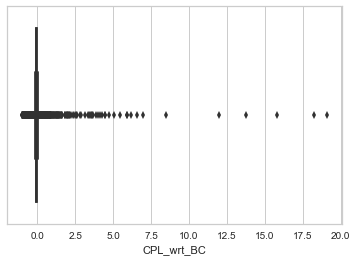

In [46]:
def main():
    
    df = pd.read_csv('data_cleaned.csv')

    print(df.keys())

    #df[df.CPL_wrt_self>180]
    import seaborn as sns

    #Q1 = df.quantile(0.25)
    #Q3 = df.quantile(0.75)
    #IQR = Q3 - Q1
    #print(IQR)

    outlier_datapoints = detect_outlier(df.clicks)
    print(outlier_datapoints)

    print(df.shape)

    for i in outlier_datapoints:
        df = df[df.clicks != i]

    print(len(outlier_datapoints))
    
    print(df.shape)

    sns.boxplot(x=df['CPL_wrt_BC'])



def detect_outlier(data):
    outliers=[]
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    
    return outliers

if __name__ == "__main__":
    main()



In [12]:
import numpy
arr = [10,1, 386, 479, 627, 20, 523, 482, 483, 542, 699, 535, 617, 577, 471, 615, 583, 441, 562, 563, 527, 453, 530, 433, 541, 585, 704, 443, 569, 430, 637, 331, 511, 552, 496, 484, 566, 554, 472, 335, 440, 579, 341, 545, 615, 548, 604, 439, 556, 442, 461, 624, 611, 444, 578, 405, 487, 490, 496, 398, 512, 422, 455, 449, 432, 607, 679, 434, 597, 639, 565, 415, 486, 668, 414, 665, 763, 557, 304, 404, 454, 689, 610, 483, 441, 657, 590, 492, 476, 437, 483, 529, 363, 711, 543]
print(len(arr))

print(outliers_iqr(arr))
print(final_list)


def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

95
(array([0, 1, 5]),)
[386, 479, 627, 523, 482, 483, 542, 699, 535, 617, 577, 471, 615, 583, 441, 562, 563, 527, 453, 530, 433, 541, 585, 704, 443, 569, 430, 637, 331, 511, 552, 496, 484, 566, 554, 472, 335, 440, 579, 341, 545, 615, 548, 604, 439, 556, 442, 461, 624, 611, 444, 578, 405, 487, 490, 496, 398, 512, 422, 455, 449, 432, 607, 679, 434, 597, 639, 565, 415, 486, 668, 414, 665, 557, 304, 404, 454, 689, 610, 483, 441, 657, 590, 492, 476, 437, 483, 529, 363, 711, 543]


In [221]:
df = pd.read_csv('data_cleaned.csv')

#'CPL_wrt_BC', 'client_state', 'duration', 'num_prods',
  #     'calls', 'CPL_wrt_self', 'churn', 'avg_budget', 'BC', 'clicks'],
#df = df.groupby('client_state')['churn'].unique()

df['clicks'].value_counts()

'''
df_states = df.iloc[:,1].value_counts()
fig= plt.figure(figsize=(12,6))
plt.plot(df_states)
plt.xticks(rotation=90)
plt.xlabel('Client States')
plt.ylabel('Number of campaigns')
plt.title('Number of campaigns in each state')
plt.show()
#df['client_state'].value_counts()

'''

89     156
75     142
87     141
88     140
82     140
72     137
99     137
86     136
100    135
94     135
84     134
83     133
98     133
85     131
106    131
91     131
80     130
90     130
77     129
79     125
92     124
96     123
104    122
107    118
97     117
73     117
74     117
76     116
95     116
109    115
      ... 
198      3
31       3
205      2
222      2
210      2
29       2
204      2
207      2
213      2
216      2
25       2
34       2
28       2
218      2
215      2
24       1
231      1
208      1
217      1
241      1
212      1
220      1
244      1
13       1
229      1
253      1
206      1
230      1
23       1
16       1
Name: clicks, Length: 203, dtype: int64

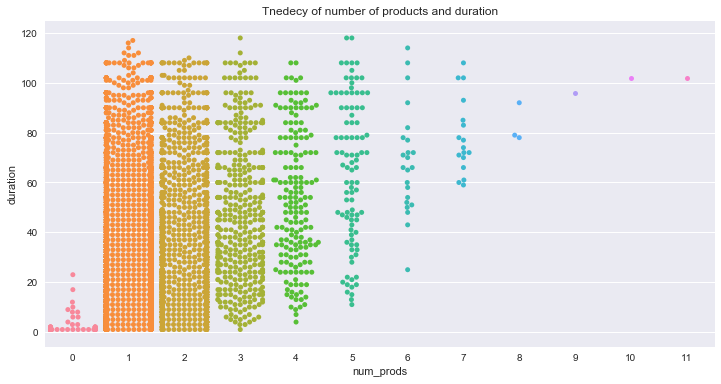

In [184]:
df = pd.read_csv('data.csv')
df['duration'] = df.iloc[:,2]
df['num_prods'] = df.iloc[:,3]
fig= plt.figure(figsize=(12,6))
plt.xlabel('Number of Products')
plt.ylabel('Duration')
plt.title('Tnedecy of number of products and duration')
sns.swarmplot(x='num_prods',y='duration', data=df)
plt.show()


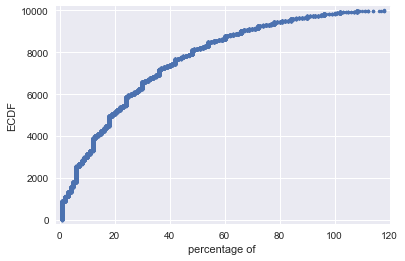

In [195]:
#df['duration'].value_counts()
df = pd.read_csv('data.csv')
x = np.sort(df.iloc[:,2])
y = np.arange(1, len(x)+1/ len(x))
plt.plot(x,y, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('percentage of ')
_ = plt.ylabel('ECDF')

20    2610
27     736
5      624
4      516
30     512
23     505
19     499
22     475
13     447
3      415
8      389
21     286
17     281
24     280
28     259
0      221
12     218
6      196
26     115
1       88
16      84
2       82
11      35
14      34
29      27
9       20
15      18
10      11
25       9
7        5
18       3
Name: BC, dtype: int64

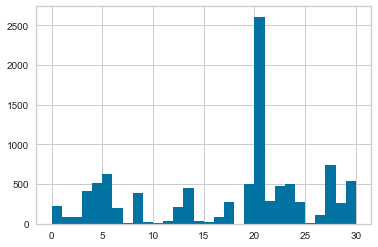

In [9]:
df = pd.read_csv('data_cleaned.csv')

x = df['BC']
#y = df['duration']
plt.hist(x, bins=30)

df['BC'].value_counts()

